# 삼중항 손실(triplet loss)이 있는 샴 네트워크(Siamese Network)를 사용한 이미지 유사도 추정

Siamese Networks는 중복 감지, anomaly detection, 얼굴 인식과 같은 다양한 사용 사례에 적용될 수 있습니다.

이 예에서는 3개의 동일한 subnetwork가 있는 샴 네트워크를 사용합니다. 모델에 3개의 이미지를 제공합니다. 여기서
그 중 두 개는 비슷할 것이고(_anchor_ 및 _positive_ sample), 세 번째는 관련이 없을 것입니다(_negative_ sample).
우리의 목표는 모델이 이미지 간의 유사성을 추정하는 방법을 배우도록 하는  것입니다.

네트워크가 학습하기 위해 삼중항 손실 함수(triple loss function)를 사용합니다.

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

- A (Anchor): 기준 표본. 특정 사람의 얼굴 이미지.  
- P (Positive): 기준 표본(A)과 같은 클래스나 카테고리에 속하는 표본. 같은 사람의 다른 얼굴 이미지.  
- N (Negative): 기준 표본(A)와 다른 클래스나 카테고리에 속하는 표본. 다른 사람의 얼굴 이미지.  
- f(x): 이미지 x를 임베딩 공간에 매핑하는 함수. 이 임베딩은 일반적으로 심층 신경망을 통해 얻어진다.  
- ‖f(A) – f(P)‖²: Anchor와 Positive 표본 간의 임베딩 공간에서의 거리의 제곱. 두 이미지가 얼마나 유사한지 표시.  
- ‖f(A) – f(N)‖²: Anchor와 Negative 표본 간의 임베딩 공간에서의 거리의 제곱.  
- Margin: 양의 마진 값으로, Positive와 Negative 사이의 거리를 얼마나 떨어져 있어야 하는지를 결정. 이 마진은 손실을 안정화하고, 모든 삼중항에 대해 각각의 거리가 너무 근접하지 않게 하는 데 도움을 준다.  

이 예시는 [Totally Looks Like dataset](https://sites.google.com/view/totally-looks-like-dataset)를 사용합니다.
[Rosenfeld et al., 2018](https://arxiv.org/pdf/1803.01485v3.pdf).  

- 데이터 세트에는 6016개의 이미지 쌍이 포함되어 있습니다.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten()
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.utils import plot_model
import time

target_shape = (200, 200)

SyntaxError: ignored

## dataset load

*Totally Looking Like* 데이터세트를 로드하고 압축을 풉니다.

데이터세트는 두 개의 개별 파일로 구성됩니다.

* `left.zip`에는 anchor로 사용할 이미지가 포함되어 있습니다.
* `right.zip`에는 positive 샘플(앵커처럼 보이는 이미지)로 사용할 이미지가 포함되어 있습니다.

In [4]:
cache_dir = Path("/content/")
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

cache_dir, anchor_images_path, positive_images_path

(PosixPath('/content'),
 PosixPath('/content/left'),
 PosixPath('/content/right'))

In [5]:
#OYJ gdrive에서 file download 및 압축 해제
!gdown 1RxrOFgTLcv_f0HLwJeGOq4kJEHVgC4m7
!gdown 1--Us3zRNRGYWNpWJBlIkXEjiNmo39_Ue

!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From: https://drive.google.com/uc?id=1RxrOFgTLcv_f0HLwJeGOq4kJEHVgC4m7
To: /content/right.zip
100% 104M/104M [00:02<00:00, 50.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1--Us3zRNRGYWNpWJBlIkXEjiNmo39_Ue
To: /content/left.zip
100% 104M/104M [00:02<00:00, 34.6MB/s]


In [ ]:
# !gdown 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
# !gdown 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW

## 데이터 준비

우리는 `tf.data` 파이프라인을 사용하여 데이터를 로드하고 Siamese 네트워크를 훈련하는 데 필요한 삼중항을 생성할 것입니다.

anchor, positive, 및 negative 파일 이름이 소스로 포함된 압축 목록을 사용하여 파이프라인을 설정합니다. 파이프라인은 해당 이미지를 로드하고 사전 처리합니다.

In [6]:
def preprocess_image(filename):
    """
    지정된 파일을 JPEG 이미지로 로드하고, 이미지를 전처리하며,
    목표 크기로 조정합니다.
    """
    image_string = tf.io.read_file(filename)   # 파일의 내용을 읽습니다.
    image = tf.image.decode_jpeg(image_string, channels=3)  # JPEG로 인코딩된 이미지를 uint8 텐서로 디코드합니다.
    image = tf.image.convert_image_dtype(image, tf.float32) # 필요한 경우 값을 조정하여 이미지의 dtype을 변환합니다.
    image = tf.image.resize(image, target_shape) # 지정된 방법을 사용하여 이미지 크기를 조정합니다.
    return image

def preprocess_triplets(anchor, positive, negative):
    """
    세 이미지에 해당하는 파일 이름이 주어지면, 해당 이미지들을 로드하고
    전처리합니다.
    """
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


anchor,  positive 및 negative 이미지 파일 이름이 소스로 포함된 압축 목록을 사용하여 데이터 파이프라인을 설정해 보겠습니다. 파이프라인의 출력에는 모든 이미지가 load 되고 사전 처리된 동일한 triplet이 포함됩니다.

앵커 이미지와 포지티브 이미지가 모두 정렬된 순서로 load 되었는지 확인하여 함께 일치시킬 수 있도록 해야 합니다.

In [9]:
os.listdir(anchor_images_path)[:5], os.listdir(positive_images_path)[:5]

(['05249.jpg', '02823.jpg', '05192.jpg', '02761.jpg', '03147.jpg'],
 ['05249.jpg', '02823.jpg', '05192.jpg', '02761.jpg', '03147.jpg'])

In [10]:
# anchor_images_path 경로에 있는 파일들의 목록을 정렬하여 anchor_images에 저장합니다.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

# positive_images_path 경로에 있는 파일들의 목록을 정렬하여 positive_images에 저장합니다.
positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

# anchor_images와 positive_images의 길이(파일 수)를 출력합니다.
print(len(anchor_images), len(positive_images))

6016 6016


In [11]:
# anchor_images로부터 텐서 슬라이스 데이터셋을 생성하여 anchor_dataset에 저장합니다.
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)

# positive_images로부터 텐서 슬라이스 데이터셋을 생성하여 positive_dataset에 저장합니다.
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# anchor_dataset와 positive_dataset에서 각각 5개의 요소를 가져와서 출력합니다.
# img1은 anchor_dataset에서, img2는 positive_dataset에서 가져온 이미지 경로입니다.
for img1, img2 in zip(anchor_dataset.take(5), positive_dataset.take(5)):
    print(img1, img2)

tf.Tensor(b'/content/left/00000.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00001.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00001.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00002.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00002.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00003.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00003.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00004.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00004.jpg', shape=(), dtype=string)


negative 이미지 목록을 생성하기 위해 사용 가능한 이미지 목록을 무작위로 만들고 함께 연결해 보겠습니다.

In [12]:
# anchor_images 목록과 positive_images 목록을 무작위로 섞기 위해 랜덤 시드값 42로 설정한 난수 생성기 생성
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)  # anchor_images 목록 섞기
rng.shuffle(positive_images)  # positive_images 목록 섞기

# anchor_images와 positive_images 목록을 합쳐서 negative_images 목록 생성
negative_images = anchor_images + positive_images
print(len(negative_images))  # negative_images의 길이(합친 후의 이미지 수) 출력

# negative_images 목록을 무작위로 섞기 위해 랜덤 시드값 32로 설정한 난수 생성기 생성
rng2 = np.random.RandomState(seed=32)
rng2.shuffle(negative_images)  # negative_images 목록 섞기

# negative_images로부터 텐서 슬라이스 데이터셋 생성
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images).shuffle(4096)

# negative_dataset에서 5개의 요소(이미지 경로)를 가져와 출력
for img in negative_dataset.take(5):
    print(img)

12032
tf.Tensor(b'/content/right/05572.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/right/03771.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/right/02120.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/right/02161.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/right/05515.jpg', shape=(), dtype=string)


In [13]:
len(anchor_dataset), len(positive_dataset), len(negative_dataset)

(6016, 6016, 12032)

In [23]:
# anchor_dataset, positive_dataset, negative_dataset를 묶어 하나의 데이터셋으로 만듭니다.
# 각 요소는 (anchor, positive, negative) 형태의 튜플
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

dataset = dataset.shuffle(buffer_size=1024).map(preprocess_triplets)

# anchor_dataset의 전체 이미지 개수를 image_count 변수에 저장
image_count = len(anchor_dataset)

# 데이터셋을 학습 및 검증 데이터셋으로 분리
# 약 80%의 데이터는 학습 데이터셋으로, 나머지 20%는 검증 데이터셋으로 사용
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

# 학습 및 검증 데이터셋을 배치 크기 32로 나누고, 나머지가 있어도 버리지 않습니다.
# 데이터를 미리 가져오는 prefetch를 사용하여 학습 속도를 최적화합니다.
train_dataset = train_dataset.batch(32, drop_remainder=False).prefetch(8)
val_dataset = val_dataset.batch(32, drop_remainder=False).prefetch(8)

# 학습 및 검증 데이터셋을 출력
train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None))>)

Triplelet의 몇 가지 예를 살펴보겠습니다. 세 번째 이미지는 항상 다른 반면 처음 두 이미지는 어떻게 유사하게 보이는지 확인하십시오.

In [24]:
def visualize(anchor, positive, negative):
    """제공된 배치에서 몇 개의 트리플릿을 시각화합니다."""

    def show(ax, image, title):
        """이미지와 제목을 사용하여 주어진 축에 이미지를 표시합니다."""
        ax.imshow(image)                       # 이미지를 축에 표시합니다.
        ax.set_title(title)                    # 제목을 설정합니다.
        ax.get_xaxis().set_visible(False)      # x축을 숨깁니다.
        ax.get_yaxis().set_visible(False)      # y축을 숨깁니다.

    fig = plt.figure(figsize=(9, 9))          # 9x9 크기의 새로운 그림을 생성합니다.

    axs = fig.subplots(3, 3)                   # 3x3의 서브플롯을 생성합니다.
    for i in range(3):
        show(axs[i, 0], anchor[i], 'anchor')   # anchor 이미지를 첫 번째 열에 표시합니다.
        show(axs[i, 1], positive[i], 'positive') # positive 이미지를 두 번째 열에 표시합니다.
        show(axs[i, 2], negative[i], 'negative') # negative 이미지를 세 번째 열에 표시합니다.

as_numpy_iterator 메소드는 Dataset의 모든 요소를 numpy로 변환하는 iterator를 리턴

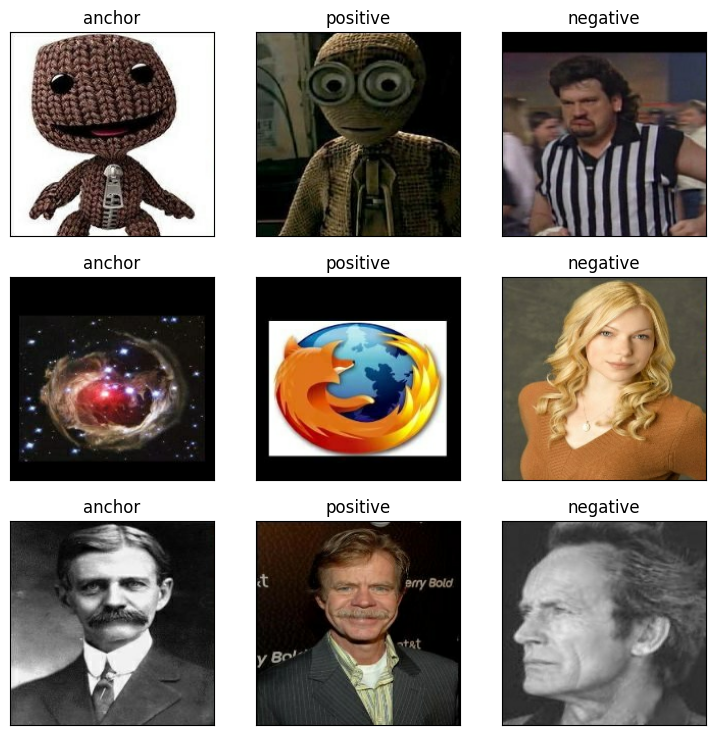

In [25]:
# train_dataset에서 첫 번째 배치의 이미지 트리플릿을 가져와 시각화합니다.

# 1. train_dataset에서 첫 번째 배치를 선택합니다.
# 2. as_numpy_iterator()를 사용하여 TensorFlow 데이터셋을 NumPy 반복자로 변환합니다.
# 3. list(...)를 통해 해당 반복자를 리스트로 변환합니다. 이렇게 되면 첫 번째 원소가 첫 번째 배치의 트리플릿 이미지 튜플이 됩니다.
# 4. [0]로 리스트의 첫 번째 원소(트리플릿 이미지 튜플)를 선택합니다.
# 5. * 연산자를 사용하여 트리플릿 이미지 튜플의 원소들을 visualize 함수의 인자로 개별적으로 전달합니다.

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## 임베딩 생성기 모델 설정

Siamese 네트워크는 삼중항의 각 이미지에 대한 임베딩을 생성합니다. 이를 위해 ImageNet에서 사전 훈련된 ResNet50 모델을 사용하고 몇 개의 'Dense' 레이어를 연결하여 이러한 임베딩을 분리하는 방법을 배울 것입니다.

모델의 모든 레이어의 가중치를 `conv5_block1_out` 레이어까지 고정합니다.
이는 모델이 이미 학습한 가중치에 영향을 미치지 않도록 하는 데 중요합니다.
우리는 훈련 중에 가중치를 미세 조정할 수 있도록 맨 아래 몇 개의 레이어를 훈련 가능한 상태로 둘 것입니다.

In [26]:
target_shape + (3,)

(200, 200, 3)

In [27]:
# ResNet50을 기반으로 하는 Convolutional Neural Network 모델을 생성합니다.
# - ImageNet으로 사전 학습된 가중치를 사용합니다.
# - 입력 이미지의 형태는 target_shape + (3,)이며, RGB 3채널을 갖습니다.
# - include_top=False는 ResNet50의 최상단(분류를 위한) 레이어는 포함하지 않겠다는 의미입니다.
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = Flatten()(base_cnn.output)
x = Dense(512, activation="relu")(flatten)
x = BatchNormalization()(x)  # 배치 정규화를 수행하는 레이어를 추가
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
output = Dense(256)(x)

# 위에서 정의한 레이어들을 통해 임베딩 모델을 생성합니다.
embedding = Model(base_cnn.input, output, name="Embedding")

# base_cnn의 특정 레이어 이후만 학습을 허용하기 위한 로직입니다.
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True  # 이 레이어 이후부터는 학습이 가능하도록 설정합니다.
    layer.trainable = trainable

94765736/94765736 [==============================] - 5s 0us/step


## 샴 네트워크 모델 설정

샴 네트워크는 각각의 삼중항 이미지를 입력으로 받아 임베딩을 생성하고 앵커와 포지티브 임베딩 사이의 거리와 앵커와 네거티브 임베딩 사이의 거리를 출력합니다.

거리를 계산하기 위해 두 값을 튜플로 반환하는 사용자 지정 레이어 'DistanceLayer'를 사용할 수 있습니다.

In [31]:
# DistanceLayer 정의: 앵커, 포지티브, 네거티브 임베딩 사이의 거리를 계산하는 사용자 정의 레이어입니다.
class DistanceLayer(layers.Layer):
    """
    이 레이어는 앵커 임베딩과 포지티브 임베딩, 앵커 임베딩과
    네거티브 임베딩 사이의 거리를 계산하는 역할을 합니다.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    # 해당 레이어의 연산을 정의합니다. 주어진 임베딩 간의 거리를 계산합니다.
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

# 3개의 입력을 정의합니다: 앵커, 포지티브, 네거티브 이미지에 대한 입력입니다.
anchor_input = Input(name="anchor", shape=target_shape + (3,))
positive_input = Input(name="positive", shape=target_shape + (3,))
negative_input = Input(name="negative", shape=target_shape + (3,))

# 각 이미지를 임베딩 모델에 통과시킨 후, 그 결과를 DistanceLayer에 넣어 거리를 계산합니다.
distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

# 앵커, 포지티브, 네거티브 입력을 받아서 거리를 출력하는 사이아미스 네트워크 모델을 생성합니다.
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [32]:
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                          

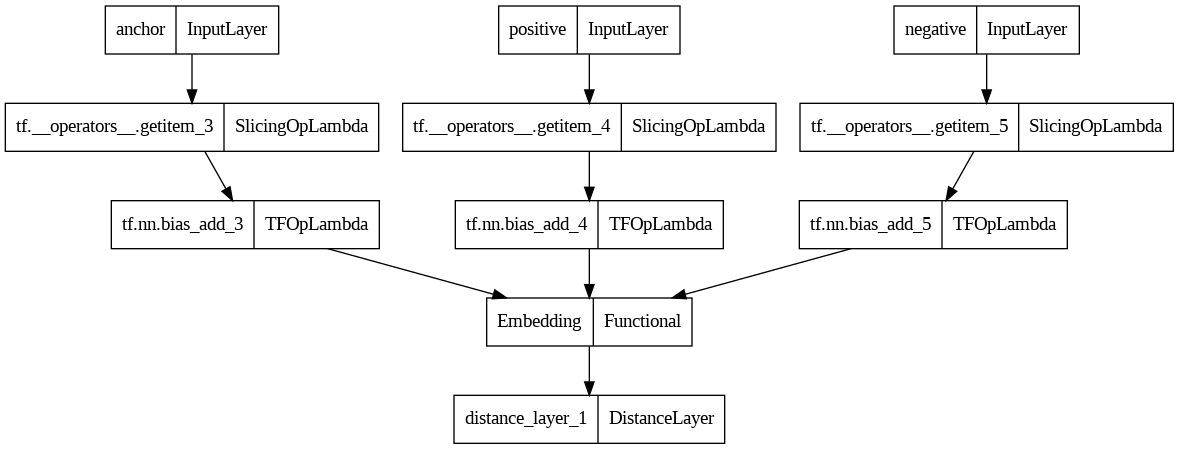

In [33]:
plot_model(siamese_network)

## Putting everything together

이제 Siamese 네트워크에서 생성된 3개의 임베딩을 사용하여 삼중항 손실을 계산할 수 있도록 사용자 지정 훈련 루프가 있는 모델을 구현해야 합니다.

훈련 과정의 손실을 추적하기 위해 'Mean' 메트릭 인스턴스를 생성해 보겠습니다.

In [34]:
class SiameseModel(Model):
    """사용자 정의 훈련 및 테스트 루프가 있는 샴 네트워크 모델.
    샴 네트워크에서 생성된 3개의 임베딩을 사용하여 삼중항 손실을 계산합니다.
    삼중항 손실은 다음과 같이 정의:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network  # 샴 네트워크
        self.margin = margin  # 마진 값 (손실을 계산할 때 사용)
        self.loss_tracker = metrics.Mean(name="loss")  # 평균 손실을 추적하는 메트릭

    def call(self, inputs):
        # Siamese network의 전방향 연산을 호출
        return self.siamese_network(inputs)

    def train_step(self, data):
        # 사용자 정의 훈련 단계. 입력 데이터에 대한 삼중항 손실을 계산하고,
        # 해당 손실에 기반하여 네트워크의 가중치를 업데이트합니다.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        # 사용자 정의 테스트 단계. 입력 데이터에 대한 손실을 계산합니다.
        loss = self._compute_loss(data)

        # 손실 메트릭 업데이트 및 반환
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # 네트워크의 출력으로부터 양의 예제와 음의 예제 사이의 거리를 계산합니다.
        ap_distance, an_distance = self.siamese_network(data)

        # 삼중항 손실 계산
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # 자동으로 `reset_states()`를 호출할 수 있도록 여기에서 메트릭을 나열합니다.
        return [self.loss_tracker]

## Training

In [35]:
# 현재 시간을 캡처하여 훈련 시간을 측정하기 위한 시작점 설정
s = time.time()

# Siamese 네트워크 모델을 초기화
siamese_model = SiameseModel(siamese_network)

# 모델을 컴파일. 옵티마이저로는 Adam을 사용하며 학습률은 0.0001로 설정
siamese_model.compile(optimizer=optimizers.Adam(0.0001))

# 모델을 학습 데이터로 훈련. 에폭은 10으로 설정하고 검증 데이터도 제공
history = siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
151/151 [==============================] - ETA: 0s - loss: 0.4915

151/151 [==============================] - 111s 547ms/step - loss: 0.4915 - val_loss: 0.3967
Epoch 2/10
151/151 [==============================] - ETA: 0s - loss: 0.3944

151/151 [==============================] - 77s 513ms/step - loss: 0.3944 - val_loss: 0.3560
Epoch 3/10
151/151 [==============================] - ETA: 0s - loss: 0.3655

151/151 [==============================] - 77s 510ms/step - loss: 0.3655 - val_loss: 0.3533
Epoch 4/10
151/151 [==============================] - ETA: 0s - loss: 0.3588

151/151 [==============================] - 76s 503ms/step - loss: 0.3588 - val_loss: 0.3360
Epoch 5/10
151/151 [==============================] - ETA: 0s - loss: 0.3369

151/151 [==============================] - 76s 502ms/step - loss: 0.3369 - val_loss: 0.3311
Epoch 6/10
151/151 [==============================] - ETA: 0s - loss: 0.3338

151/151 [==============================] - 77s 511ms/step - loss: 0.3338 - val_loss: 0.3230
Epoch 7/10
151/151 [==============================] - ETA: 0s - loss: 0.3101

151/151 [==============================] - 77s 507ms/step - loss: 0.3101 - val_loss: 0.3211
Epoch 8/10
151/151 [==============================] - ETA: 0s - loss: 0.3025

151/151 [==============================] - 77s 508ms/step - loss: 0.3025 - val_loss: 0.3499
Epoch 9/10
151/151 [==============================] - ETA: 0s - loss: 0.3038

151/151 [==============================] - 76s 504ms/step - loss: 0.3038 - val_loss: 0.3315
Epoch 10/10
151/151 [==============================] - ETA: 0s - loss: 0.2989

151/151 [==============================] - 76s 506ms/step - loss: 0.2989 - val_loss: 0.3249


In [36]:
print("경과 시간 (분):", (time.time() - s)/60)

경과 시간 (분): 14.581987607479096


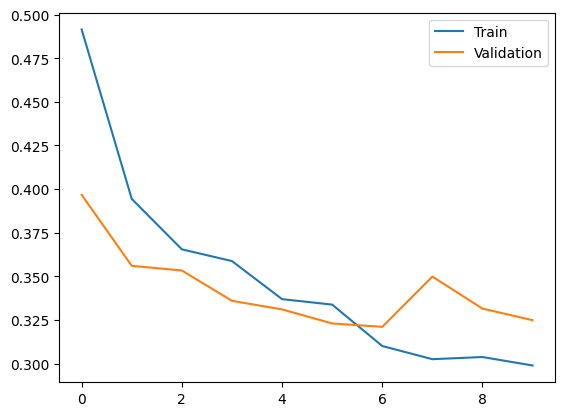

In [37]:
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.legend()

## 네트워크가 학습한 내용 검사

이제 네트워크가 유사한 이미지에 속하는지 여부에 따라 임베딩을 분리하는 방법을 학습한 것을 확인할 수 있습니다.

[코사인 유사도](https://en.wikipedia.org/wiki/Cosine_similarity)를 사용하여 임베딩 간의 유사도를 측정할 수 있습니다.

데이터 세트에서 샘플을 선택하여 각 이미지에 대해 생성된 임베딩 간의 유사성을 확인하겠습니다.

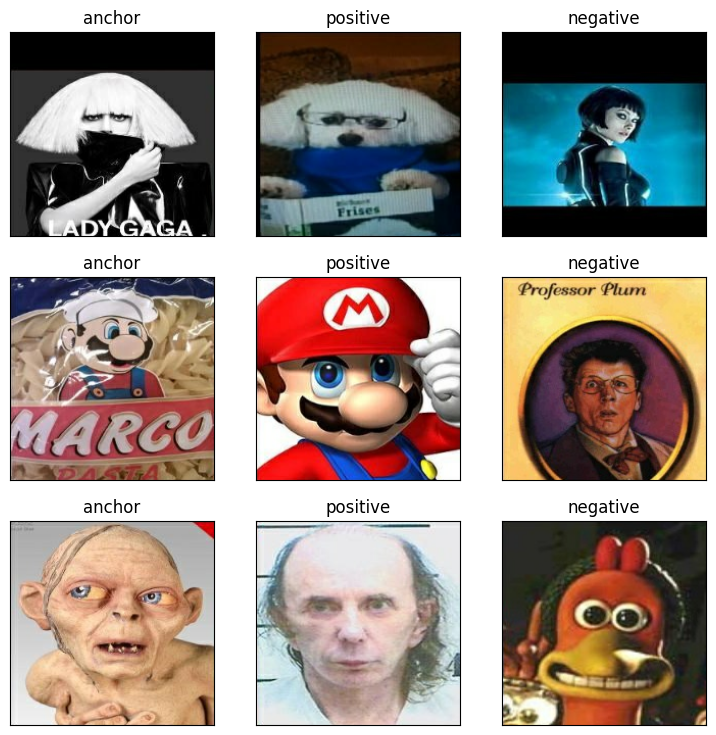

In [38]:
# 훈련 데이터셋에서 첫 번째 배치를 가져옴
sample = next(iter(train_dataset))

# 해당 샘플의 이미지를 시각화 (앵커, 포지티브, 네거티브)
visualize(*sample)

# 샘플을 앵커, 포지티브, 네거티브로 분리
anchor, positive, negative = sample

# 각 이미지를 전처리한 후 임베딩 모델을 통해 임베딩을 얻음
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

마지막으로 앵커와 포지티브 이미지 간의 코사인 유사도를 계산하고 앵커와 네거티브 이미지 간의 유사도와 비교할 수 있습니다.

앵커와 포지티브 이미지 사이의 유사도가 앵커와 네거티브 이미지 간의 유사도보다 클 것으로 예상 합니다.

In [39]:
# 코사인 유사도를 계산하기 위한 객체 생성
cosine_similarity = metrics.CosineSimilarity()

# 앵커와 포지티브 사이의 코사인 유사도를 계산
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

# 앵커와 네거티브 사이의 코사인 유사도를 계산
negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99429655
Negative similarity 0.9919552
